In [1]:
import FalseColor.Color as fc
from FalseColor.FCdataobject import DataObject
import numpy as np
import os
%matplotlib inline
import matplotlib.pyplot as plt
import h5py as h5
import scipy.ndimage as nd
import skimage as sk
import cv2
import copy

In [2]:
#method for viewing plots
def ViewImage(Images,title=None,do_hist = False,
              figsize = (6,4), range_min=0,
              range_max=None,cmap='viridis'):
    if do_hist:
        f,ax = plt.subplots(ncols = 2,figsize = figsize)
        ax[0].imshow(Images)
        ax[0].set_title('Image')
        if range_max is None:
            range_max = Images.max()
        ax[1].hist(Images[Images != 0].ravel(),256,[range_min,range_max])
        ax[1].set_title('Histogram')
        if title is not None:
            f.suptitle(title)
    else:
        f,ax = plt.subplots(figsize=figsize)
        ax.imshow(Images,cmap=cmap)
        if title is not None:
            ax.set_title(title)
    return f,ax



In [3]:
#create runnable for CPU processing
runnable_dict = {'runnable':fc.falseColor,'kwargs': None}

In [4]:
#load data in ./h5_sample_data/example_data.h5
file_path = os.path.join(os.getcwd(),'h5_sample_data/prostate')

#setup DataObject with hdf5 imageSet
Dataset = DataObject(file_path)
Dataset.setupH5data()

(16, 1024, 1024, 2)


(<Figure size 576x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1c19bc8b0f0>)

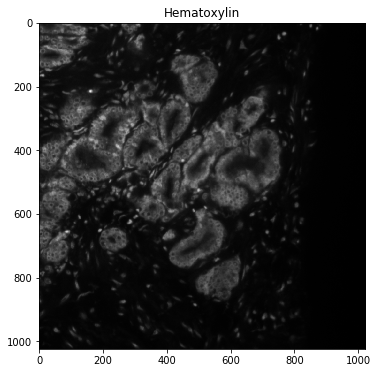

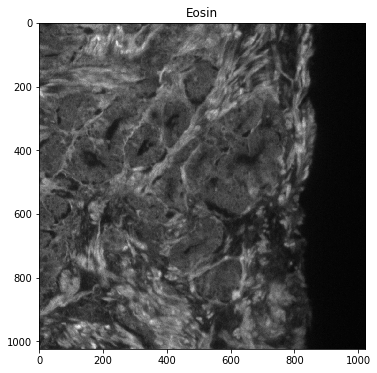

In [9]:
#view raw data
ViewImage(Dataset.imageSet[0,:,:,0], title = 'Hematoxylin', cmap = 'gray', figsize = (8,6))
ViewImage(Dataset.imageSet[0,:,:,1], title = 'Eosin', cmap = 'gray', figsize = (8,6))

In [5]:
#run parallel processing on multiple CPU cores
pseudo_colored_data = Dataset.processImages(runnable_dict,Dataset.imageSet)

<function falseColor at 0x000001C1947278C8> None (16, 1024, 1024, 2)


(<Figure size 432x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1c199f346d8>)

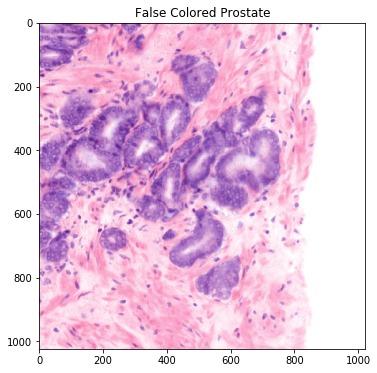

In [6]:
#View results
ViewImage(pseudo_colored_data[0,0],title='False Colored Prostate',figsize=(6,6))

In [7]:
nuclei = copy.deepcopy(Dataset.imageSet[:,:,:,0]).astype(float)
cyto = copy.deepcopy(Dataset.imageSet[:,:,:,1]).astype(float)
nuclei.shape

(16, 1024, 1024)

In [11]:
#Background subtraction and sharpening
nuc_bg = fc.getBackgroundLevels(nuclei[-1])[1]
cyto_bg = fc.getBackgroundLevels(cyto[-1])[1]

#subtract background
nuclei_nobackground = copy.deepcopy(nuclei) - nuc_bg
nuclei_nobackground = np.clip(nuclei_nobackground,0,65535)

cyto_nobackground = copy.deepcopy(cyto) - 0.75*cyto_bg
cyto_nobackground = np.clip(cyto_nobackground,0,65535)

sharp_nuclei = np.zeros(nuclei_nobackground.shape)
sharp_cyto = np.zeros(cyto_nobackground.shape)

for i in range(len(nuclei_nobackground)):
    sharp_nuclei[i] = fc.sharpenImage(nuclei_nobackground[i])
    sharp_cyto[i] = fc.sharpenImage(cyto_nobackground[i])

In [12]:
#Calculate flat field
nuc_flatfield = fc.getFlatField(sharp_nuclei)[0]
cyto_flatfield = fc.getFlatField(sharp_cyto)[0]
print(nuc_flatfield.shape)

(1, 64, 64)


In [13]:
#reshape flat field so they are the same size as image
nuc_flatfield = nd.interpolation.zoom(nuc_flatfield[0], 16, order = 1, mode = 'nearest')
cyto_flatfield = nd.interpolation.zoom(cyto_flatfield[0], 16, order = 1, mode = 'nearest')
print(nuc_flatfield.shape)

(1024, 1024)


In [14]:
#get RGB settings
settings_dict = fc.getDefaultRGBSettings()
nuclei_RGBsettings = settings_dict['nuclei']
cyto_RGBsettings = settings_dict['cyto']

In [15]:
#execute GPU accelerated false coloring on two individual images using standard background subtraction
original_settings = fc.rapidFalseColor(sharp_nuclei[0],sharp_cyto[0],
                                       nuclei_RGBsettings,cyto_RGBsettings,
                                       run_normalization=True, 
                                       cyto_normfactor = 3*cyto_flatfield,
                                       nuc_normfactor = 0.6*nuc_flatfield
                                       )

(<Figure size 432x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x16607a42e80>)

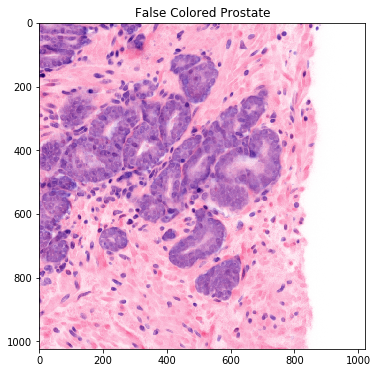

In [16]:
ViewImage(original_settings,figsize=(6,6),title='False Colored Prostate')